# AIMS SENEGAL, Jan 2026
# Numerical Integration   
### Upper/Lower Sums, Trapezoid (Newton–Cotes), Simpson + Real-World Applications (with Exercises)

This notebook is designed for a **Numerical Optimization: Numerical Integration** course.

**Goal:** show how numerical integration is used in real data workflows to:
- compute totals from rates (energy from power, distance from speed, total rainfall),
- compute area under curves (AUC-like ideas),
- create features (exposure, load, cumulative risk),
- connect to optimization (choose parameters to minimize integrated cost).

We will cover:
1. Riemann sums (lower & upper sums)
2. Trapezoid method (Newton–Cotes)
3. Simpson's rule (Newton–Cotes)
4. Real-world examples: distance from GPS speed, energy consumption from power
5. Data science features: cumulative exposure and AUC-style metrics
6. Exercises 


## 0. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, suppress=True)


## 1. Why numerical integration?

Integration converts a **rate** into a **total**:

- Speed (km/h) → Distance (km)
- Power (kW) → Energy (kWh)
- Rainfall rate (mm/h) → Total rainfall (mm)
- Concentration over time → Exposure (medicine, pollution)

Given samples of a function $f(t)$, we want:

$$
\int_a^b f(t)\,dt
$$

But we only have discrete measurements, so we approximate numerically.


## 2. Riemann sums: lower and upper sums

Assume sample points $t_0, t_1, \dots, t_n$.

### Left Riemann sum
$$
S_L = \sum_{k=0}^{n-1} f(t_k)\,(t_{k+1}-t_k)
$$

### Right Riemann sum
$$
S_R = \sum_{k=1}^{n} f(t_k)\,(t_k-t_{k-1})
$$

### General lower/upper sums (interval min/max)
Even if $f$ is not monotone, we can bound the integral by using the minimum/maximum
of the endpoints on each interval:

$$
S_{\text{lower}} = \sum_k \min(f_k, f_{k+1})\,h_k,\quad
S_{\text{upper}} = \sum_k \max(f_k, f_{k+1})\,h_k.
$$


In [2]:
def riemann_left(t, f):
    t = np.asarray(t, dtype=float)
    f = np.asarray(f, dtype=float)
    h = np.diff(t)
    return np.sum(f[:-1] * h)

def riemann_right(t, f):
    t = np.asarray(t, dtype=float)
    f = np.asarray(f, dtype=float)
    h = np.diff(t)
    return np.sum(f[1:] * h)

def riemann_lower_upper(t, f):
    t = np.asarray(t, dtype=float)
    f = np.asarray(f, dtype=float)
    h = np.diff(t)
    lower = np.sum(np.minimum(f[:-1], f[1:]) * h)
    upper = np.sum(np.maximum(f[:-1], f[1:]) * h)
    return lower, upper


## 3. Trapezoid method (Newton–Cotes)

The trapezoid rule approximates each interval by a trapezoid:

$$
\int_{t_k}^{t_{k+1}} f(t)\,dt \approx \frac{h_k}{2}\big(f_k + f_{k+1}\big)
$$

Summing:
$$
S_T = \sum_{k=0}^{n-1} \frac{h_k}{2}(f_k + f_{k+1})
$$


In [3]:
def trapezoid(t, f):
    t = np.asarray(t, dtype=float)
    f = np.asarray(f, dtype=float)
    h = np.diff(t)
    return np.sum(0.5 * (f[:-1] + f[1:]) * h)

def cumulative_trapezoid(t, f):
    t = np.asarray(t, dtype=float)
    f = np.asarray(f, dtype=float)
    h = np.diff(t)
    incr = 0.5 * (f[:-1] + f[1:]) * h
    return np.concatenate([[0.0], np.cumsum(incr)])


## 4. Simpson's rule (Newton–Cotes)

For uniform spacing $h$ and an even number of subintervals $n$:

$$
S_S = \frac{h}{3}\Big[f_0 + f_n + 4\sum_{k \text{ odd}} f_k + 2\sum_{k \text{ even},\,k\neq 0,n} f_k\Big]
$$

Simpson is often more accurate for smooth functions.


In [4]:
def simpson_uniform(t, f):
    t = np.asarray(t, dtype=float)
    f = np.asarray(f, dtype=float)
    n = len(t) - 1
    if n % 2 == 1:
        raise ValueError("Simpson requires an even number of subintervals.")
    h = (t[-1] - t[0]) / n
    if np.max(np.abs(np.diff(t) - h)) > 1e-8:
        raise ValueError("simpson_uniform expects nearly uniform spacing.")
    S = f[0] + f[-1]
    S += 4 * np.sum(f[1:-1:2])
    S += 2 * np.sum(f[2:-1:2])
    return (h/3) * S


## 5. Sanity check with a known function

Let $f(t)=\sin(t)$. True value:
$$
\int_0^\pi \sin(t)\,dt = 2.
$$


In [6]:
t = np.linspace(0, np.pi, 101)  # 100 subintervals
f = np.sin(t)
true_val = 2.0

L = riemann_left(t, f)
R = riemann_right(t, f)
lo, up = riemann_lower_upper(t, f)
T = trapezoid(t, f)
S = simpson_uniform(t, f)

print("True integral:", true_val)
print("Left sum:     ", L)
print("Right sum:    ", R)
print("Lower bound:  ", lo)
print("Upper bound:  ", up)
print("Trapezoid:    ", T)
print("Simpson:      ", S)


# True signal and noise
rng = np.random.default_rng(42)
epsilon = rng.normal(0, 0.1, size=len(t))  # noise
x = np.sin(t) + epsilon
dx_true = np.cos(t) 
def finite_diff_forward(t, x):
    h = np.diff(t)
    dx = np.zeros_like(x)
    dx[:-1] = (x[1:] - x[:-1]) / h
    dx[-1] = dx[-2]  # replicate last value
    return dx
def finite_diff_backward(t, x):
    h = np.diff(t)
    dx = np.zeros_like(x)
    dx[1:] = (x[1:] - x[:-1]) / h
    dx[0] = dx[1]  # replicate first value
    return dx
def finite_diff_central(t, x):
    h = np.diff(t)
    dx = np.zeros_like(x)
    dx[1:-1] = (x[2:] - x[:-2]) / (h[1:] + h[:-1])
    dx[0] = dx[1]      # replicate first value
    dx[-1] = dx[-2]    # replicate last value
    return dx
dx_f = finite_diff_forward(t, x)
dx_b = finite_diff_backward(t, x)
dx_c = finite_diff_central(t, x)
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))
print("RMSE forward :", rmse(dx_true, dx_f))
print("RMSE backward:", rmse(dx_true, dx_b))
print("RMSE central :", rmse(dx_true, dx_c))

True integral: 2.0
Left sum:      1.9998355038874434
Right sum:     1.9998355038874436
Lower bound:   1.9684195773515456
Upper bound:   2.031251430423342
Trapezoid:     1.9998355038874434
Simpson:       2.000000010824504
RMSE forward : 3.3256356822327025
RMSE backward: 3.3485551651844068
RMSE central : 1.7021902339158657


## 6. Real-world application 1: Distance from speed (transport / GPS)

Speed sensor reports speed every minute (km/h).  
Distance traveled is:

$$
\text{Distance} = \int v(t)\,dt
$$

We compute distance using:
- left/right sums (bounds),
- trapezoid (standard),
- Simpson (if uniform & even subintervals).


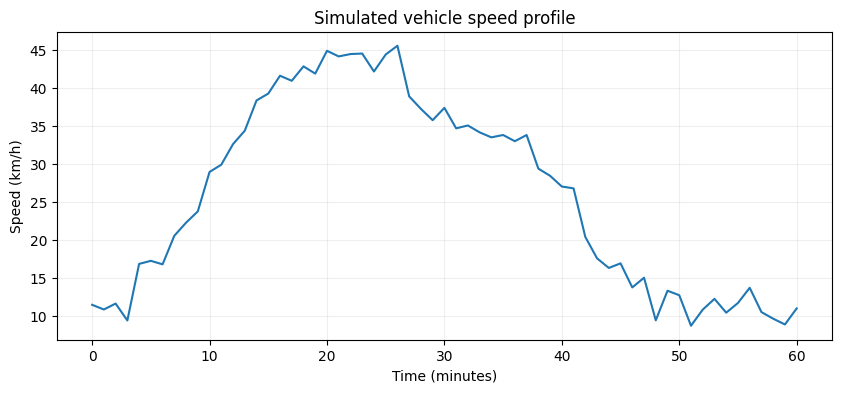

Distance estimates (km):
Left sum  : 26.231427576415275
Right sum : 26.223551600010552
Trapezoid : 26.22748958821291
Simpson   : 26.185779686996998
Check bound: left <= trap <= right ? False


In [7]:
rng = np.random.default_rng(2)

minutes = np.arange(0, 61)   # 0..60
t_hours = minutes / 60.0     # hours

v = 10 + 35*(1/(1+np.exp(-(minutes-10)/3)) - 1/(1+np.exp(-(minutes-40)/3)))
v += -20*(1/(1+np.exp(-(minutes-30)/2)) - 1/(1+np.exp(-(minutes-34)/2)))
v += rng.normal(0, 1.5, size=len(v))
v = np.clip(v, 0, None)

plt.figure(figsize=(10,4))
plt.plot(minutes, v)
plt.xlabel("Time (minutes)")
plt.ylabel("Speed (km/h)")
plt.title("Simulated vehicle speed profile")
plt.grid(True, alpha=0.2)
plt.show()

dist_left  = riemann_left(t_hours, v)
dist_right = riemann_right(t_hours, v)
dist_trap  = trapezoid(t_hours, v)
dist_simp  = simpson_uniform(t_hours, v)  # 60 subintervals even

print("Distance estimates (km):")
print("Left sum  :", dist_left)
print("Right sum :", dist_right)
print("Trapezoid :", dist_trap)
print("Simpson   :", dist_simp)
print("Check bound: left <= trap <= right ?", dist_left <= dist_trap <= dist_right)


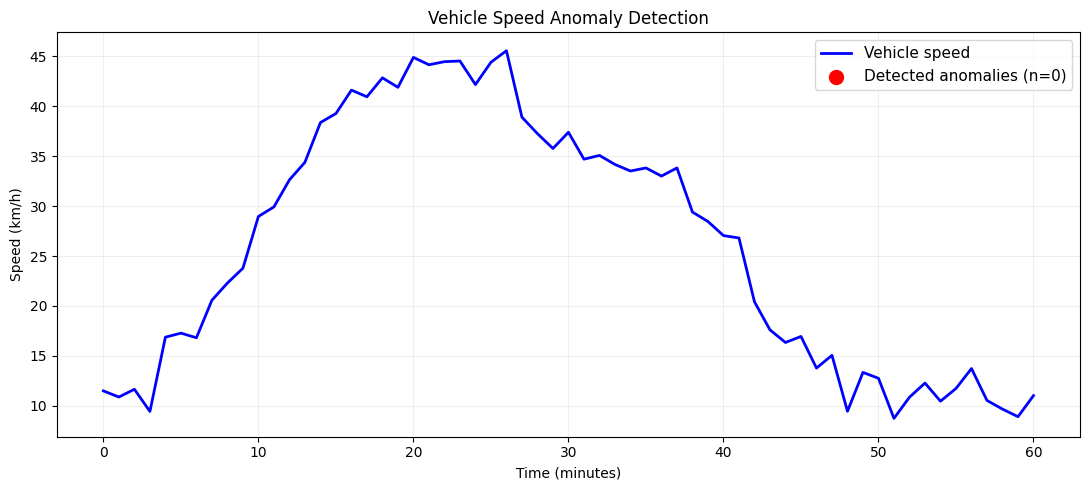

Anomalies detected at minutes: []


In [ ]:
# Anomaly detection from vehicle speed data

def diff_central(x, h=1.0):
    """Central difference: more accurate for derivatives"""
    x = np.asarray(x, dtype=float)
    d = np.empty_like(x, dtype=float)
    d[0]  = (x[1] - x[0]) / h
    d[-1] = (x[-1] - x[-2]) / h
    d[1:-1] = (x[2:] - x[:-2]) / (2*h)
    return d

# Compute derivatives
h_minutes = 1.0
dv = diff_central(v, h_minutes)      # acceleration
ddv = diff_central(dv, h_minutes)    # jerk

# Detect anomalies
tau_accel = 5.0
tau_jerk = 3.0
anomaly_idx = np.where((np.abs(dv) > tau_accel) | (np.abs(ddv) > tau_jerk))[0]

#Speed with anomalies
plt.figure(figsize=(11, 5))
plt.plot(minutes, v, linewidth=2, label="Vehicle speed", color='blue')
plt.scatter(minutes[anomaly_idx], v[anomaly_idx], color='red', s=100, 
           label=f"Detected anomalies (n={len(anomaly_idx)})", zorder=5, marker='o')
plt.xlabel("Time (minutes)")
plt.ylabel("Speed (km/h)")
plt.title("Vehicle Speed Anomaly Detection")
plt.grid(True, alpha=0.2)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"Anomalies detected at minutes: {minutes[anomaly_idx]}")


### Cumulative distance (feature engineering)

A common feature/KPI is cumulative distance over time:
$$
D(t_k) = \int_{t_0}^{t_k} v(t)\,dt.
$$

We compute it incrementally using the trapezoid rule.


In [ ]:
cum_dist = cumulative_trapezoid(t_hours, v)

plt.figure(figsize=(10,4))
plt.plot(minutes, cum_dist)
plt.xlabel("Time (minutes)")
plt.ylabel("Cumulative distance (km)")
plt.title("Cumulative distance feature via trapezoid integration")
plt.grid(True, alpha=0.2)
plt.show()

print("Total distance:", cum_dist[-1])


## 7. Real-world application 2: Energy from power (smart meter)

A smart meter measures power $P(t)$ every 15 minutes (kW).
Energy in kWh:

$$
E = \int P(t)\,dt
$$

(when time is in hours)


In [ ]:
t = np.arange(0, 24.0 + 0.25, 0.25)  # hours, 15 min step
rng = np.random.default_rng(3)

P = 0.6 + 1.8*(1/(1+np.exp(-(t-7)/1.0)) - 1/(1+np.exp(-(t-11)/1.2)))
P += 1.2*(1/(1+np.exp(-(t-17)/1.0)) - 1/(1+np.exp(-(t-21)/1.2)))
P += rng.normal(0, 0.08, size=len(P))
P = np.clip(P, 0.1, None)

plt.figure(figsize=(10,4))
plt.plot(t, P)
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("Simulated power consumption (smart meter)")
plt.grid(True, alpha=0.2)
plt.show()

E_left = riemann_left(t, P)
E_right = riemann_right(t, P)
E_trap = trapezoid(t, P)
E_simp = simpson_uniform(t, P)  # 96 subintervals even

print("Energy estimates (kWh):")
print("Left sum  :", E_left)
print("Right sum :", E_right)
print("Trapezoid :", E_trap)
print("Simpson   :", E_simp)

cum_E = cumulative_trapezoid(t, P)
plt.figure(figsize=(10,4))
plt.plot(t, cum_E)
plt.xlabel("Time (hours)")
plt.ylabel("Cumulative energy (kWh)")
plt.title("Cumulative energy feature via trapezoid integration")
plt.grid(True, alpha=0.2)
plt.show()

print("Total daily energy:", cum_E[-1], "kWh")


## 8. AUC-style concept: exposure over time

If $c(t)$ is a concentration curve (pollution or drug level), total exposure is:

$$
\text{Exposure} = \int c(t)\,dt.
$$

This is an “area under curve” feature used in health/environment analytics.


In [ ]:
t = np.linspace(0, 8, 161)  # 8 hours
rng = np.random.default_rng(5)

c = 30 + 25*np.exp(-0.5*(t-3.2)**2) + 8*np.exp(-0.5*(t-6.2)**2) + rng.normal(0, 1.0, size=len(t))
c = np.clip(c, 0, None)

plt.figure(figsize=(10,4))
plt.plot(t, c)
plt.xlabel("Time (hours)")
plt.ylabel("Concentration (µg/m³)")
plt.title("Simulated concentration over time")
plt.grid(True, alpha=0.2)
plt.show()

exposure_trap = trapezoid(t, c)
print("Total exposure (trap):", exposure_trap, "(µg·h/m³)")


## 9. Optimization link: choose a threshold to minimize integrated risk

Define integrated risk above a threshold $\theta$:
$$
J(\theta) = \int \max(0, c(t) - \theta)^2 \, dt.
$$

We choose $\theta$ to minimize $J(\theta)$ (grid search).


In [ ]:
def integrated_risk(t, c, theta):
    return trapezoid(t, np.maximum(0, c-theta)**2)

theta_grid = np.linspace(20, 60, 401)
J = np.array([integrated_risk(t, c, th) for th in theta_grid])
theta_star = theta_grid[np.argmin(J)]

plt.figure(figsize=(8,4))
plt.plot(theta_grid, J)
plt.axvline(theta_star, linestyle="--", linewidth=1)
plt.xlabel("Threshold θ")
plt.ylabel("Integrated risk J(θ)")
plt.title(f"Best θ ≈ {theta_star:.2f}")
plt.grid(True, alpha=0.2)
plt.show()

print("Optimal θ:", theta_star)


## 10. Exercises (with solutions)

### Exercise 1 — Upper/lower bounds
Using the vehicle speed series:
1. Compute left, right, trapezoid.
2. Compute lower/upper using min/max per interval.
3. Verify trapezoid is inside bounds.

✅ Solution below.


In [27]:
minutes = np.arange(0, 61)   # 0..60
t_hours = minutes / 60.0     # hours
v = 10 + 35*(1/(1+np.exp(-(minutes-10)/3)) - 1/(1+np.exp(-(minutes-40)/3)))
v += -20*(1/(1+np.exp(-(minutes-30)/2)) - 1/(1+np.exp(-(minutes-34)/2)))
v += rng.normal(0, 1.5, size=len(v))
v = np.clip(v, 0, None)

dL = riemann_left(t_hours, v)
dR = riemann_right(t_hours, v)
dT = trapezoid(t_hours, v)
lower_bound, upper_bound = riemann_lower_upper(t_hours, v)



print("Distance estimates (km):")
print("Left sum  :", dL)
print("Right sum :", dR)
print("Trapezoid :", dT)
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

print("Check bound: lower <= trapezoid <= upper ?", lower_bound <= dT <= upper_bound)


Distance estimates (km):
Left sum  : 25.991623858977654
Right sum : 25.954249003661843
Trapezoid : 25.972936431319745
Lower bound: 24.929403036323222
Upper bound: 27.016469826316275
Check bound: lower <= trapezoid <= upper ? True


### Exercise 2 — Peak-hour energy KPI
Using the power series:
1. Compute cumulative energy.
2. Compute energy between 17:00 and 21:00 (peak hours).
3. Report both KPIs.

✅ Solution below.


### Exercise 3 — Trapezoid vs Simpson accuracy
For $f(t)=\sin(t)$ on $[0,\pi]$ with different $N$:
- compute trapezoid and Simpson errors
- observe Simpson converges faster (typically)

✅ Solution below.


## 11. Takeaways

- Integration converts **rates → totals** (speed→distance, power→energy).
- Left/right sums give simple bounds; min/max sums give general bounds.
- Trapezoid is a strong default for real data.
- Simpson is often more accurate for smooth data (uniform spacing + even intervals).
- Integrals create meaningful features: cumulative distance, energy, exposure.
- Optimization can minimize an **integrated cost**.

**Class activity:** we can give you a CSV time series and ask them to compute totals and cumulative features with different methods.
